# Drastic Data Handling
#### to split or refine parameters for better decomposition

In [1]:
import time
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition.candecomp_parafac import initialize_factors, unfolding_dot_khatri_rao, KruskalTensor

In [2]:
# for sample video
from cv2 import VideoWriter, VideoWriter_fourcc

def make_video(tensor, filename):
    start = time.time()
    height = tensor.shape[1]
    width = tensor.shape[2]
    FPS = 24

    fourcc = VideoWriter_fourcc(*'MP42')
    video = VideoWriter(filename, fourcc, float(FPS), (width, height))

    for frame in tensor:
        video.write(np.uint8(frame))
    video.release()
    print('created', filename, time.time()-start)

In [3]:
import math
class Welford(object):
    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)

In [4]:
def construct_tensor(factors):
    weights = tl.ones(factors[0].shape[1])
    est_tensor = tl.kruskal_to_tensor((weights, factors))
    return est_tensor
    
def print_tensor(X, n_digit=1):
    print(np.round(X, n_digit))
    
def compare_tensors(A, B):
    error_norm = tl.norm(A - B)
    print('||A-B||:', error_norm)
    return error_norm
    
def create_tensor_stream(X, start_to_stream, batch_sizes):
    total_batch_size = np.sum(batch_sizes)
    if X.shape[0] != start_to_stream + total_batch_size:
        raise ValueError('Total batch size should be the size of streaming part of the tensor.')
    
    X_stream = [X[:start_to_stream]]
    batch_start = start_to_stream
    for batch_size in batch_sizes:
        batch_end = batch_start + batch_size
        X_stream.append(X[batch_start:batch_end])
        batch_start = batch_end
    return np.asarray(X_stream)
    
def get_KhatriRao(factors):
    n_dim = len(factors)
    lefts = [factors[n_dim-1]]
    rights = [factors[0]]
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            lefts.append(tl.tenalg.khatri_rao((lefts[mode-1], factors[n_dim-mode-1])))
            rights.append(tl.tenalg.khatri_rao((factors[mode], rights[mode-1])))
            
    K = lefts.copy()
    K[0] = lefts[n_dim-2]
    K.append(rights[n_dim-2].copy())
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((lefts[n_dim-mode-2], rights[mode-1]))
    return K

def get_KhatriRao_except0(factors):
    n_dim = len(factors)
    lefts = np.empty((n_dim), dtype=object)
    rights = np.empty((n_dim), dtype=object)
    K = np.empty((n_dim), dtype=object)
    
    lefts[1] = factors[n_dim-1]
    rights[1] = factors[1]
    if n_dim > 3:
        for mode in range(2, n_dim-1):
            lefts[mode] = tl.tenalg.khatri_rao((factors[n_dim-mode], lefts[mode-1]))
            rights[mode] = tl.tenalg.khatri_rao((rights[mode-1], factors[mode]))
            
    K[1] = lefts[n_dim-2]
    K[n_dim-1] = rights[n_dim-2]
    if n_dim > 3: 
        for mode in range(2, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((rights[mode-1], lefts[n_dim-mode-1]))
    return K
    
def get_Hadamard(factors):
    rank = factors[0].shape[1]
    H = tl.tensor(np.ones((rank, rank)))
    for factor in factors:
        H = H * tl.dot(tl.transpose(factor), factor)
    return H

## Online CP

In [5]:
def online_cp(factors_old, X_old, X_new, rank, P, Q, n_iter=1, mu=1, verbose=False, transformed=False):
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    if not transformed:
        K = get_KhatriRao_except0(factors_old)
    H = get_Hadamard(factors_old[1:])
        
    for i in range(n_iter):
        # temporal mode for A1
        if not transformed:
            mttkrp = tl.dot(tl.unfold(X_new, 0), tl.tenalg.khatri_rao((U[1], K[1])))
        else:
            # for higher accracy, lower speed
            mttkrp_parts = []
            for r in range(rank):
                component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
                mttkrp_parts.append(component)
            mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            
            if not transformed:
                dP = tl.dot(tl.unfold(X_new, mode), tl.tenalg.khatri_rao((A1, K[mode])))
                UTU  = tl.dot(tl.transpose(U[mode]), U[mode])
                dQ = tl.dot(tl.transpose(A1), A1) * H / UTU
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(mu*Q[mode] + dQ), tl.transpose(mu*P[mode] + dP)))
#                 K = updated K due to non-temporal mode change
#                 H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode]) / UTU
                P[mode] = P[mode] + dP
                Q[mode] = Q[mode] + dQ
            else:
                U1 = U.copy()
                U1[0] = A1
                
                H_mode  = H / tl.dot(tl.transpose(U[mode]), U[mode])
                V = (mu * tl.dot(tl.transpose(U[0]), U[0]) + tl.dot(tl.transpose(A1), A1)) * H_mode
                
                mttkrp0 = unfolding_dot_khatri_rao(X_old, (None, U), mode)
                mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mu*mttkrp0 + mttkrp1)))
                H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode])
                
        # temporal mode for A0
        if transformed:
            mttkrp = unfolding_dot_khatri_rao(X_old, (None, U), 0)
            U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
#         else:
#             V = tl.tensor(np.ones((rank, rank)))
#             W = tl.tensor(np.ones((rank, rank)))
#             for j, factor in enumerate(U):
#                 factor_old = factors_old[j]
#                 if j != 0:
#                     V = V * tl.dot(tl.transpose(factor), factor)
#                     W = W * tl.dot(tl.transpose(factor_old), factor)
#             mttkrp = tl.dot(factors_old[0], W)
#             U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))
            
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0], A1))
    return (KruskalTensor((weights, U)), P, Q)

## DTD

In [6]:
def dtd(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    for i in range(n_iter):
        # temporal mode for A1
        V = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
        mttkrp = unfolding_dot_khatri_rao(X_new, (None, U), 0)
        A1 = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            U1 = U.copy()
            U1[0] = A1
            V = tl.tensor(np.ones((rank, rank)))
            W = tl.tensor(np.ones((rank, rank)))
            for j, factor in enumerate(U):
                factor_old = factors_old[j]
                if j != mode:
                    W = W * tl.dot(tl.transpose(factor_old), factor)
                    if j == 0:
                        V = V * (mu*tl.dot(tl.transpose(factor), factor) + tl.dot(tl.transpose(A1), A1))
                    else:
                        V = V * tl.dot(tl.transpose(factor), factor)
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))

        # temporal mode for A0
        V = tl.tensor(np.ones((rank, rank)))
        W = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            factor_old = factors_old[j]
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
                W = W * tl.dot(tl.transpose(factor_old), factor)
        mttkrp = tl.dot(factors_old[0], W)
        U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

## Online Tensor Decomposition
* `onlinecp`, `transformed_onlinecp`, `dtd`

In [29]:
from warnings import warn

def get_z_score(x, mean, std):
    if std == 0:
        return 0
    return (x - mean) / std

def online_tensor_decomposition(X_stream, rank, n_iter=1, ul=-1, ll=-1, verbose=False, method='onlinecp'):
    ktensors = []
    verbose_list = []
    if method == 'onlinecp':
        if n_iter > 1:
            warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))
            n_iter = 1
        onlinecp = True
        transformed = False
    elif method == 'transformed_onlinecp':
        onlinecp = True
        transformed = True
    elif method == 'dtd':
        onlinecp = False
    else:
        raise ValueError('The method does not exist.')        
        
    X_old = X_stream[0]
    n_dim = tl.ndim(X_old)

    start = time.time()
    (weights, factors) = parafac(X_old, rank, init='random')
    print('making init decomposition result:', time.time()-start)
    
    welford = Welford()
    X_est = construct_tensor(factors)
    err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
    welford(err_norm * 1.5)
    
    if onlinecp:
        start = time.time()
        print('\n >> onlinecp rank-{} n_iter-{} transformed-{}'.format(rank, n_iter, transformed))
        K = get_KhatriRao_except0(factors)
        H = get_Hadamard(factors)

        P = np.empty((n_dim), dtype=object)
        Q = np.empty((n_dim), dtype=object)
    
        for mode in range(1, n_dim):
            P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
            Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
        print('init_time:', time.time()-start)
    else:
        print('\n >> dtd rank-{} n_iter-{}'.format(rank, n_iter))
        
    for i, X_new in enumerate(X_stream[1:]):
        
        start = time.time()
        if onlinecp:
            ((weights, factors0), P0, Q0) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=1, verbose=False, transformed=transformed)
        else:
            (weights, factors0) = dtd(factors, X_old, X_new, rank, n_iter=n_iter, mu=1, verbose=False)
        
        U = factors0.copy()
        U[0] = U[0][-X_new.shape[0]-1:-1]
        dX_est = construct_tensor(U)
        
        err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
        z_score = get_z_score(err_norm, welford.mean, welford.std)
        
        if ul > 0 and z_score > ul:
            weights = tl.ones(rank)
            ktensors.append(KruskalTensor((weights, factors.copy())))
            print('=== SPLIT({}, {}) ==='.format(z_score, err_norm))
            welford = Welford()
            
            X_old = X_stream[i]

            (weights, factors) = parafac(X_old, rank, init='random')
            elapsed_time = time.time()-start
            print('making init decomposition result:', time.time()-start)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])

            start = time.time()
            X_est = construct_tensor(factors)
            err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
            welford(err_norm * 2)

            if onlinecp:
                K = get_KhatriRao_except0(factors)
                H = get_Hadamard(factors)

                P = np.empty((n_dim), dtype=object)
                Q = np.empty((n_dim), dtype=object)

                for mode in range(1, n_dim):
                    P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
                    Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
            
            z_score = get_z_score(err_norm, welford.mean, welford.std)
            welford(err_norm)
            elapsed_time = time.time()-start
            print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])
            continue
        elif ll > 0 and z_score > ll:
            print('=== REFINE({}, {}) ==='.format(z_score, err_norm))
            elapsed_time = time.time()-start
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])
            welford = Welford()
            if onlinecp:
                ((weights, factors), P, Q) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=0.1, verbose=False, transformed=transformed)
            else:
                (weights, factors) = dtd(factors, X_old, X_new, rank, n_iter=n_iter, mu=0.1, verbose=False)

            U = factors.copy()
            U[0] = U[0][-X_new.shape[0]-1:-1]
            dX_est = construct_tensor(U)
            err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
        else:
            if onlinecp:
                P = P0
                Q = Q0
            factors = factors0
        z_score = get_z_score(err_norm, welford.mean, welford.std)
        welford(err_norm)
        elapsed_time = time.time()-start
        print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
        verbose_list.append([i+1, elapsed_time, err_norm, z_score])
        
        X_old = np.concatenate((X_old, X_new))
        
        if verbose:
            X_est = construct_tensor(factors)
            compare_tensors(X_old, X_est)
    
    weights = tl.ones(rank)
    ktensors.append(KruskalTensor((weights, factors)))
    return (ktensors, np.asarray(verbose_list))

In [31]:
import matplotlib.pyplot as plt
def execute_online_tensor_decomposition(X_stream, rank=5, n_iter=1, ul=5, ll=3, verbose=False, methods=['onlinecp', 'transformed_onlinecp', 'dtd']):
    
    filename = 'results/rank{}-n_iter{}'.format(rank, n_iter)
    
    for method in methods:
        ktensors, verbose_list = online_tensor_decomposition(X_stream, rank, n_iter, ul, ll, verbose, method)
        X_est = construct_tensor(ktensors[0][1])
        for (weights, factors) in ktensors[1:]:
            X_est = tl.tensor(np.concatenate((X_est, construct_tensor(factors))))
        global_error_norm = compare_tensors(X, X_est)
#         make_video(X_est, '{}-{}.avi'.format(filename, method))
        
        f = open('{}-{}.txt'.format(filename, method),'w')
        np.savetxt(f, np.asarray([global_error_norm]), delimiter="\n")
        np.savetxt(f, np.asarray(verbose_list), delimiter=" ")
        f.close()
        
        plt.figure(1)
        plt.plot(verbose_list[:,0], verbose_list[:,1], label=method, linewidth=0.5)
        plt.figure(2)
        plt.plot(verbose_list[:,0], verbose_list[:,2], label=method, linewidth=0.5)

    plt.figure(1)
    plt.legend(loc='upper left')
    plt.ylabel('running time for a data slice')
    plt.xlabel('# of data slices')
    plt.savefig('{}-{}.png'.format(filename, 'running_time'), dpi=500)
    
    plt.figure(2)
    plt.legend(loc='upper left')
    plt.ylabel('local error norm for a data slice')
    plt.xlabel('# of data slices')
    plt.savefig('{}-{}.png'.format(filename, 'local_error_norm'), dpi=500)
    plt.show()

### Load Sample Video Dataset

In [167]:
import csv
sample_video = tl.tensor(np.zeros([205, 240, 320, 3], dtype='d'))

for i in range(41):
    start = time.time()
    with open('../Data/sample_video/data/video{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            sample_video[tuple(indices)] = np.double(row[-1])
    print('>> sample_video{} loaded '.format(i), time.time() - start)

>> sample_video0 loaded  29.479700326919556
>> sample_video1 loaded  28.99581813812256
>> sample_video2 loaded  28.61942148208618
>> sample_video3 loaded  28.49720311164856
>> sample_video4 loaded  28.357536792755127
>> sample_video5 loaded  28.227654933929443
>> sample_video6 loaded  29.03157091140747
>> sample_video7 loaded  28.906013011932373
>> sample_video8 loaded  28.88797426223755
>> sample_video9 loaded  26.495742797851562
>> sample_video10 loaded  23.42308235168457
>> sample_video11 loaded  23.179828882217407
>> sample_video12 loaded  24.9242684841156
>> sample_video13 loaded  24.034982919692993
>> sample_video14 loaded  25.516217708587646
>> sample_video15 loaded  24.972158432006836
>> sample_video16 loaded  24.871618270874023
>> sample_video17 loaded  23.10366988182068
>> sample_video18 loaded  23.201594591140747
>> sample_video19 loaded  24.558634996414185
>> sample_video20 loaded  24.274433851242065
>> sample_video21 loaded  23.257092237472534
>> sample_video22 loaded  23.

In [340]:
make_video(sample_video, './sample_video/original.avi')

created ./sample_video/original.avi 0.24576997756958008


In [ ]:
X = sample_video
X_stream = create_tensor_stream(X, start_to_stream=5, batch_sizes=np.full((40), 5, dtype=int))

for n_iter in range(1, 6):
    for rank in range(30, 101, 10):
        execute_online_tensor_decomposition(X_stream, rank, n_iter, ul=5, ll=3, verbose=False)

### Load Synthetic Dataset

In [339]:
import csv
synthetic_data = tl.tensor(np.zeros([1000, 10, 20, 30], dtype='d'))

for i in range(200):
    start = time.time()
    with open('../Data/synthetic_data/data_normal/data{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            synthetic_data[tuple(indices)] = np.double(row[-1])
    print('>> synthetic_data{} loaded '.format(i), time.time() - start)

>> synthetic_data0 loaded  0.6587352752685547
>> synthetic_data1 loaded  0.6081960201263428
>> synthetic_data2 loaded  0.6025619506835938
>> synthetic_data3 loaded  0.6006972789764404
>> synthetic_data4 loaded  0.5865089893341064
>> synthetic_data5 loaded  0.6084511280059814
>> synthetic_data6 loaded  0.6134665012359619
>> synthetic_data7 loaded  0.6209592819213867
>> synthetic_data8 loaded  0.6313679218292236
>> synthetic_data9 loaded  0.6341166496276855
>> synthetic_data10 loaded  0.6156368255615234
>> synthetic_data11 loaded  0.5843431949615479
>> synthetic_data12 loaded  0.6143205165863037
>> synthetic_data13 loaded  0.60231614112854
>> synthetic_data14 loaded  0.5957744121551514
>> synthetic_data15 loaded  0.6110448837280273
>> synthetic_data16 loaded  0.5905382633209229
>> synthetic_data17 loaded  0.6121666431427002
>> synthetic_data18 loaded  0.6043610572814941
>> synthetic_data19 loaded  0.5962996482849121
>> synthetic_data20 loaded  0.62760329246521
>> synthetic_data21 loaded 

In [ ]:
X = synthetic_data
X_stream = create_tensor_stream(X, start_to_stream=5, batch_sizes=np.full((199), 5, dtype=int))
execute_online_tensor_decomposition(X_stream, rank=10, n_iter=1, ul=1, ll=0.5, verbose=False)

### Load Server Room CFD

In [34]:
import csv
server_room_cfd = tl.tensor(np.zeros([3000, 3, 3, 34], dtype='d'))

start = time.time()
welford = Welford()
with open('../Data/ServerRoomCFD.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))-1])[[3, 0, 1, 2]]
        
        if indices[0] < 3000:
            server_room_cfd[tuple(indices)] = np.double(row[-1])
            welford(np.double(row[-1]))
server_room_cfd = (server_room_cfd - welford.mean) / welford.std
print('>> ServerRoomCFD loaded ', time.time() - start)

>> ServerRoomCFD loaded  20.07682991027832


<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (5 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.04975485801696777

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0012657642364501953
1th_iter: 0.001767873764038086 0.22702903220120402 0
2th_iter: 0.0017604827880859375 0.33274209416444817 1.3736649845619935
3th_iter: 0.0017533302307128906 0.3124980160673488 0.7417440444311764
4th_iter: 0.0017409324645996094 0.29631290223950013 0.5132385976226131
5th_iter: 0.0016474723815917969 0.2890555718754018 0.40468431126596
6th_iter: 0.0017094612121582031 0.310638803977389 0.546034896554473
7th_iter: 0.0016338825225830078 0.23746099127868842 -0.1348458983382102
8th_iter: 0.0016498565673828125 0.18124814677304335 -0.6533866757954835
9th_iter: 0.00164031982421875 0.18910539745526697 -0.5281462386300738
10th_iter: 0.0015592575073242188 0.24007103613318234 0.022266466370625546
11th_iter: 0.0015978813171386719 0.31218868283124784 0.7949972445962069
12th_iter: 0.0015633106231689453 0.4137380159180008 1.8539374999600668
=== REFINE(2.390091134856019, 0.4

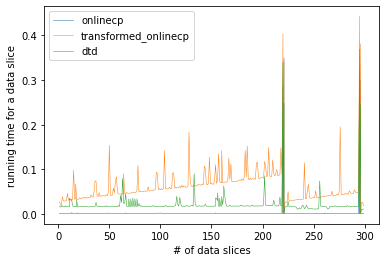

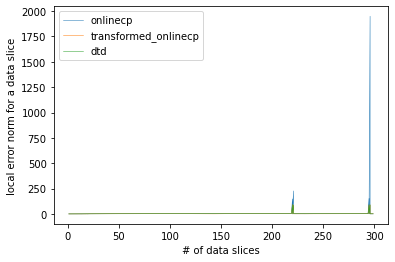

In [36]:
X = server_room_cfd
X_stream = create_tensor_stream(X, start_to_stream=10, batch_sizes=np.full((299), 10, dtype=int))
execute_online_tensor_decomposition(X_stream, rank=5, n_iter=5, ul=3, ll=2, verbose=False)

### Load Stock Data

In [14]:
import csv
stock_data = tl.tensor(np.zeros([3000, 200, 5], dtype='d'))

start = time.time()
with open('../Data/Stock.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))])[[1, 0, 2]]
        if indices[0] < 3000:
            stock_data[tuple(indices)] = np.double(row[-1])
print('>> stock_data loaded ', time.time() - start)

>> stock_data loaded  46.033480167388916


<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (5 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.19414472579956055

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0005209445953369141
1th_iter: 0.0010797977447509766 145371.42740359696 0
2th_iter: 0.0008745193481445312 172520.36645166553 1.3767365954622888
3th_iter: 0.0008401870727539062 130247.69226078986 -0.11733955530561058
4th_iter: 0.0008254051208496094 146784.63340997335 0.36085344341275655
5th_iter: 0.0013093948364257812 150188.4257770483 0.43713312701956536
6th_iter: 0.0008263587951660156 122745.7232088032 -0.5679535480193204
7th_iter: 0.0008366107940673828 151709.22940617442 0.5695919042838936
8th_iter: 0.0008358955383300781 172701.46260234452 1.3588553016481872
9th_iter: 0.0008218288421630859 178811.59342218505 1.3954257863898407
10th_iter: 0.0008449554443359375 183600.0670148101 1.3820547366662836
=== REFINE(3.5009688359872473, 248261.9097886512) ===
11th_iter: 0.0018284320831298828 135036.61104836772 0
12th_iter: 0.0008289813995361328 254195.03566449712 0
13th_iter: 0.0008

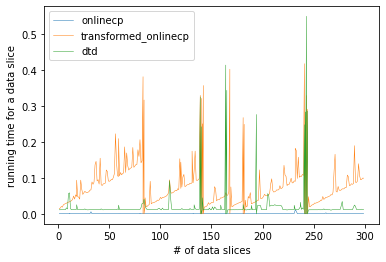

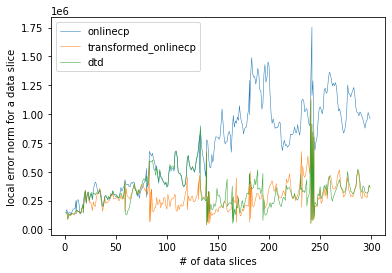

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (5 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.5556910037994385

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007283687591552734
1th_iter: 0.001333475112915039 140308.08282811524 0
2th_iter: 0.0013165473937988281 152386.2854716764 0.9056365702835885
3th_iter: 0.0012891292572021484 90421.58652932654 -0.4716227376101275
4th_iter: 0.0012984275817871094 139450.1902965329 0.6620534259105039
5th_iter: 0.0012886524200439453 115375.26968521983 0.00019407052123698117
6th_iter: 0.001302480697631836 108162.56281666021 -0.19359123170872522
7th_iter: 0.0012941360473632812 141758.7158618578 0.8043664729904203
8th_iter: 0.001298666000366211 133175.36847257786 0.4667196036039851
9th_iter: 0.0012927055358886719 123942.40264210617 0.14257979736499388
10th_iter: 0.0012943744659423828 127780.66950975395 0.26583983826295066
11th_iter: 0.0012869834899902344 104606.4764507584 -0.5698745899564157
12th_iter: 0.0012865066528320312 125409.97276627456 0.22434502530126557
13th_iter: 0.0012886524200439453 113

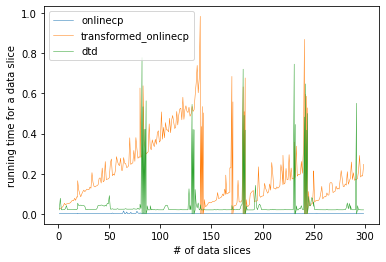

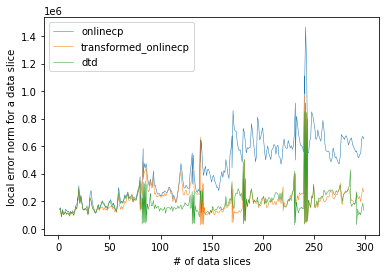

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (10 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.23047137260437012

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006392002105712891
1th_iter: 0.0011165142059326172 159299.49382202892 0
2th_iter: 0.0011038780212402344 177948.54594423203 1.1074095971069553
3th_iter: 0.0011010169982910156 213720.92328804065 1.5799068579778026
4th_iter: 0.0011029243469238281 154558.41002047883 -0.12957077240049714
5th_iter: 0.0010988712310791016 164543.44292675177 0.10857665768291119
6th_iter: 0.0011036396026611328 209679.57399251888 1.2519315507172528
7th_iter: 0.0011000633239746094 263937.3246217883 2.3891418528636112
8th_iter: 0.0011081695556640625 235181.55001267235 1.0990596164541433
9th_iter: 0.0010983943939208984 163800.59906056407 -0.43350117317307385
10th_iter: 0.001115560531616211 155369.8658851675 -0.5838098566461553
11th_iter: 0.0010979175567626953 214888.3955131874 0.725232891355677
12th_iter: 0.0011093616485595703 270436.7018482767 1.900288270143411
13th_iter: 0.0011010169982910156 285585.

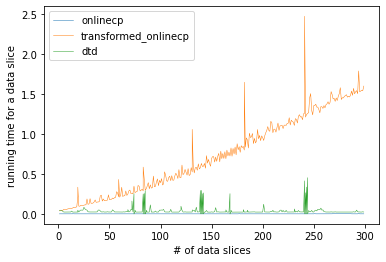

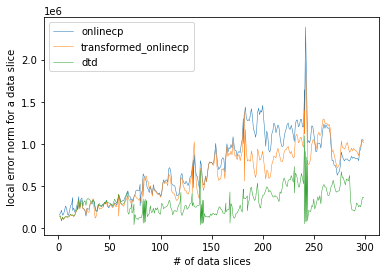

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (10 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.41484618186950684

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007214546203613281
1th_iter: 0.0012297630310058594 138350.3058459202 0
2th_iter: 0.0012211799621582031 154447.0185392927 0.9797468605251543
3th_iter: 0.0012178421020507812 91469.72980482873 -0.4566665922291327
4th_iter: 0.0012137889862060547 138604.8510777473 0.6359293090153395
5th_iter: 0.0012102127075195312 106847.8633884735 -0.21051071964066415
6th_iter: 0.0012099742889404297 107836.81438481681 -0.1685938797024659
7th_iter: 0.0012128353118896484 138604.0011005886 0.7477360410482886
8th_iter: 0.001214742660522461 119286.76514925537 0.0889598974221575
9th_iter: 0.0012106895446777344 117720.23944934281 0.03331960140690913
10th_iter: 0.0012135505676269531 126328.72060407665 0.33005479165483587
11th_iter: 0.008333921432495117 107435.97211323155 -0.3716469600476426
12th_iter: 0.001219034194946289 127638.19583707573 0.4096869559265818
13th_iter: 0.0012269020080566406 119320.

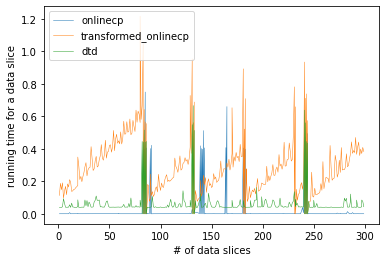

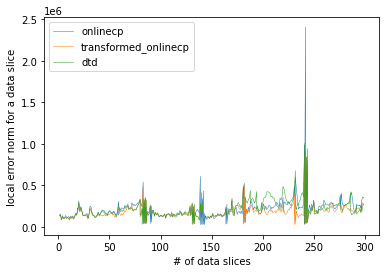

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (15 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.2465503215789795

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006680488586425781
1th_iter: 0.001232147216796875 157213.96011419088 0
2th_iter: 0.0011496543884277344 176321.39522854963 1.1309899298309036
3th_iter: 0.0011472702026367188 224800.82080506923 1.9007761357506248
4th_iter: 0.0011370182037353516 159490.62681708566 -0.06364373556830895
5th_iter: 0.001142740249633789 161819.4485628524 -0.00931921545327985
6th_iter: 0.0011358261108398438 200517.8316367267 0.9098436917420021
7th_iter: 0.0011475086212158203 250056.7695082456 2.00482447722632
8th_iter: 0.0011429786682128906 204504.32771581202 0.5539027826358363
9th_iter: 0.0011322498321533203 158263.54090744272 -0.49564670798855814
10th_iter: 0.0011327266693115234 160686.61188103663 -0.41124845465461035
11th_iter: 0.0011436939239501953 224397.63561774348 1.1341415819859517
12th_iter: 0.0011441707611083984 271484.4268535038 2.1492126709051393
13th_iter: 0.0011417865753173828 292352.

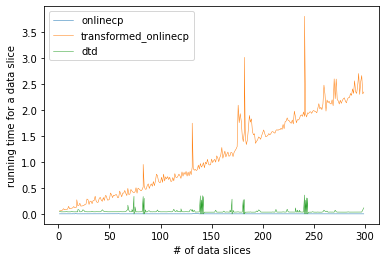

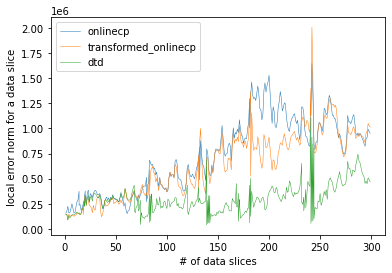

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (15 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.4250802993774414

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007491111755371094
1th_iter: 0.0012128353118896484 139744.83182769816 0
2th_iter: 0.0012052059173583984 155278.48499105455 0.9603613418267678
3th_iter: 0.0011944770812988281 90015.39107757228 -0.4716182589775476
4th_iter: 0.0012061595916748047 139658.5596969521 0.6436395076075886
5th_iter: 0.001203298568725586 115981.28597988785 0.010324543244810446
6th_iter: 0.0012063980102539062 113587.60942130578 -0.052986128253506445
7th_iter: 0.0012083053588867188 126980.63974127368 0.3338890601546783
8th_iter: 0.0012059211730957031 113440.3185848821 -0.10253190330613922
9th_iter: 0.0012028217315673828 116885.44543334778 0.01559027193690501
10th_iter: 0.0012068748474121094 127091.41744482111 0.3698054945595914
11th_iter: 0.0012080669403076172 103315.87461482675 -0.5136365803950323
12th_iter: 0.001210927963256836 126236.23768156666 0.3768367213928088
13th_iter: 0.0012023448944091797 1

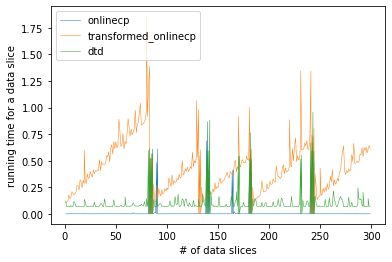

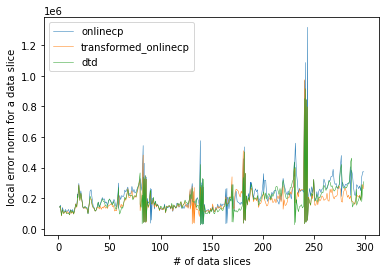

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (20 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.25972461700439453

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0007185935974121094
1th_iter: 0.001214742660522461 147608.1883822436 0
2th_iter: 0.0012166500091552734 172284.5529409769 1.3019482720432716
3th_iter: 0.0011980533599853516 160949.82816689616 0.5762927171937423
4th_iter: 0.0012061595916748047 147936.73548831546 0.14812772380126424
5th_iter: 0.001199483871459961 163407.38506374307 0.6169535764046924
6th_iter: 0.0012054443359375 129708.00815573735 -0.5731435684501552
7th_iter: 0.0011982917785644531 149627.86075550024 0.1860710859981546
8th_iter: 0.001219034194946289 173081.44563567484 1.0756756913809855
9th_iter: 0.0012023448944091797 180732.76605208602 1.2476289741764883
10th_iter: 0.0012080669403076172 184400.50219546363 1.2361674944092576
11th_iter: 0.0012106895446777344 232194.29502003617 2.860474967650048
12th_iter: 0.001207113265991211 242065.66867494865 2.36670054197913
13th_iter: 0.0012040138244628906 210770.359491023

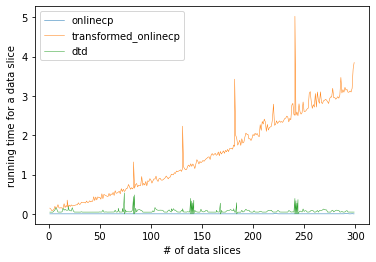

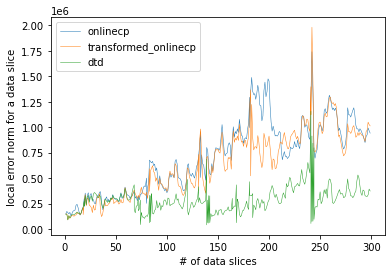

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (20 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.402148962020874

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007102489471435547
1th_iter: 0.0012667179107666016 144065.8134163579 0
2th_iter: 0.001247406005859375 159557.91455746486 0.9466221596515068
3th_iter: 0.0012524127960205078 92280.93011435975 -0.4577081364485022
4th_iter: 0.0012423992156982422 138220.70927736265 0.5323947791037592
5th_iter: 0.0012538433074951172 124502.17256911557 0.16260117881693198
6th_iter: 0.001247406005859375 111140.58813742593 -0.18731444440043205
7th_iter: 0.0012547969818115234 137994.7506846847 0.5674340683417162
8th_iter: 0.0012421607971191406 137012.26600574312 0.4954352268063047
9th_iter: 0.001249074935913086 119442.65281545972 -0.07645288038999379
10th_iter: 0.0012471675872802734 122807.25439711373 0.03670550909677005
11th_iter: 0.001247406005859375 94300.89621486931 -0.944132475818243
12th_iter: 0.0012333393096923828 117914.79514345551 -0.0546824618731782
13th_iter: 0.001257181167602539 104348.5

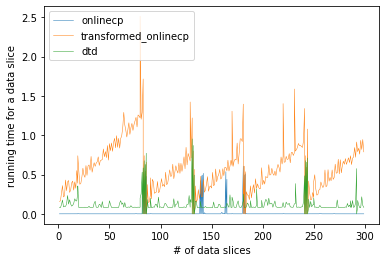

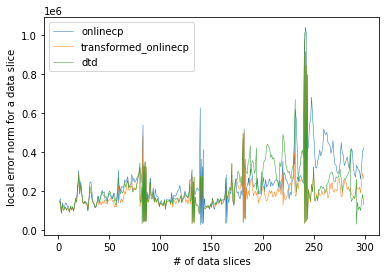

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (25 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.2330329418182373

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006418228149414062
1th_iter: 0.0011303424835205078 144532.63234838436 0
2th_iter: 0.0011086463928222656 174056.5166773289 1.4234315242766098
3th_iter: 0.0010933876037597656 177663.96993908045 0.9560285599798833
4th_iter: 0.001096963882446289 150300.27384973064 0.11059926026967046
5th_iter: 0.0010890960693359375 158840.20263099243 0.33486980174006076
6th_iter: 0.0010929107666015625 130265.57143566143 -0.5527337945976387
7th_iter: 0.0010993480682373047 149530.7741388744 0.11406663694721392
8th_iter: 0.008630752563476562 172759.97884421144 0.9143790912480524
9th_iter: 0.0011034011840820312 180499.73902647762 1.0993476348466615
10th_iter: 0.001107931137084961 184247.69985671615 1.116282170463926
11th_iter: 0.0010998249053955078 232677.3283522754 2.6981431213491667
12th_iter: 0.0011060237884521484 246897.2083990529 2.411967552254835
13th_iter: 0.0010983943939208984 221978.75860

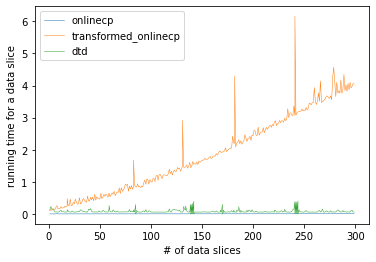

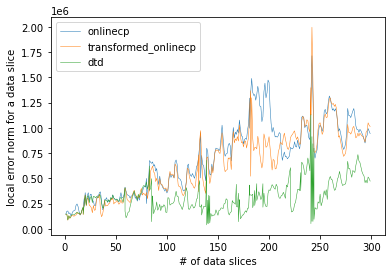

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (25 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.4681060314178467

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007302761077880859
1th_iter: 0.0013124942779541016 141594.57749629716 0
2th_iter: 0.001312255859375 152950.836787866 0.8966767907302278
3th_iter: 0.0012869834899902344 89546.46907480569 -0.5256099798155072
4th_iter: 0.001272439956665039 139529.08222074452 0.6503824302974206
5th_iter: 0.0012784004211425781 114744.52911307494 -0.032932318930552366
6th_iter: 0.0012793540954589844 111158.12642237433 -0.1281372454677786
7th_iter: 0.0012831687927246094 134880.49131828913 0.585027590103835
8th_iter: 0.001398324966430664 110543.38576522657 -0.22300063949913426
9th_iter: 0.0012881755828857422 116867.21347088474 -6.747255557159949e-05
10th_iter: 0.0013763904571533203 128454.64118311436 0.4103543041133015
11th_iter: 0.0012888908386230469 105152.80528584246 -0.47274733928550083
12th_iter: 0.00128936767578125 126812.86417221699 0.382629139305351
13th_iter: 0.0012879371643066406 115990

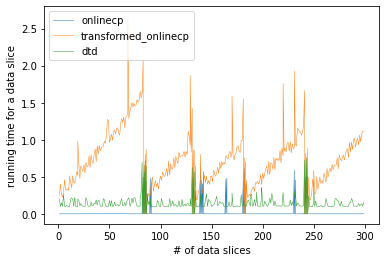

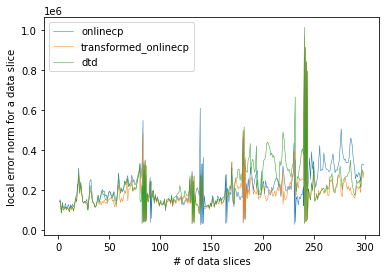

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (30 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.22891783714294434

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006775856018066406
1th_iter: 0.0014147758483886719 144845.61324109253 0
2th_iter: 0.0014162063598632812 174248.17661560618 1.4166167108459224
3th_iter: 0.0011165142059326172 128582.1541427268 -0.14572185124868542
4th_iter: 0.0011034011840820312 147019.74738776428 0.36867810000107076
5th_iter: 0.0011205673217773438 148586.46065733477 0.38294794382903574
6th_iter: 0.0011060237884521484 121465.17656355847 -0.5710450075442614
7th_iter: 0.0011019706726074219 150990.07909259235 0.5488010575856365
8th_iter: 0.001100778579711914 172949.9096472041 1.3494431444043913
9th_iter: 0.0010943412780761719 179400.37349304784 1.3938805074659668
10th_iter: 0.0011038780212402344 184468.19955821638 1.3851981448138393
=== REFINE(3.390844546992697, 248029.29673847943) ===
11th_iter: 0.0023076534271240234 134616.27559966542 0
12th_iter: 0.0018429756164550781 255963.747469171 0
13th_iter: 0.001100

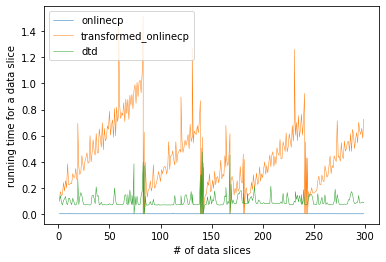

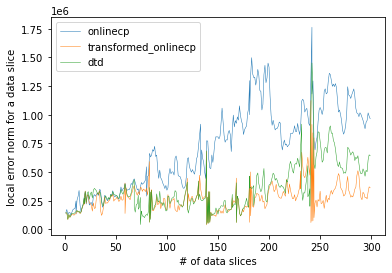

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (30 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.4725666046142578

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007886886596679688
1th_iter: 0.0013813972473144531 140295.44893430886 0
2th_iter: 0.0016674995422363281 150115.74944074478 0.8719381346805973
3th_iter: 0.0013725757598876953 87168.13813414305 -0.5475435608218532
4th_iter: 0.0013625621795654297 137712.72941757605 0.6580985479741976
5th_iter: 0.0013604164123535156 122627.09730991027 0.20525174419831502
6th_iter: 0.0013580322265625 110336.71581829381 -0.14546606889733352
7th_iter: 0.0013642311096191406 129208.97468143277 0.4275933645806145
8th_iter: 0.0014691352844238281 140522.97151888738 0.7592342659879665
9th_iter: 0.0013616085052490234 122392.54645167725 0.10046038041243271
10th_iter: 0.0021495819091796875 120851.74749843104 0.042154416277650576
11th_iter: 0.0013654232025146484 100058.46810229008 -0.7232874779081806
12th_iter: 0.001369476318359375 120843.0410320226 0.10280727469724174
13th_iter: 0.0013811588287353516 111

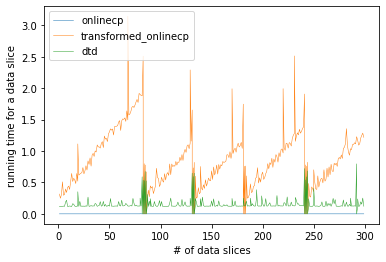

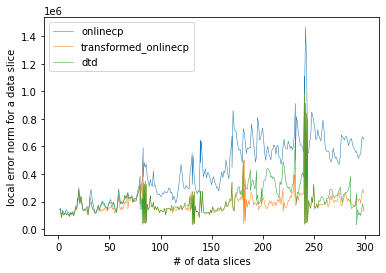

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (35 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.2455754280090332

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006511211395263672
1th_iter: 0.0011136531829833984 144668.19070504655 0
2th_iter: 0.0011050701141357422 172751.18373731937 1.407513386535301
3th_iter: 0.0011141300201416016 164012.24131223984 0.6687581944804952
4th_iter: 0.0011029243469238281 148428.5202330761 0.1595316359816591
5th_iter: 0.0011186599731445312 164659.86300704084 0.6370361745116152
6th_iter: 0.0010998249053955078 131184.30412925273 -0.5153719323092809
7th_iter: 0.0011119842529296875 150144.7699605387 0.18529573954197784
8th_iter: 0.0011036396026611328 172088.11128117295 0.9958560704632764
9th_iter: 0.0011258125305175781 179190.8932530108 1.1596250110974218
10th_iter: 0.0011038780212402344 183901.53570327378 1.2072446766824705
=== REFINE(3.0540858230848205, 237720.63242070412) ===
11th_iter: 0.002419710159301758 126204.93214482558 0
12th_iter: 0.001102447509765625 236424.16646367047 0
13th_iter: 0.0011041164

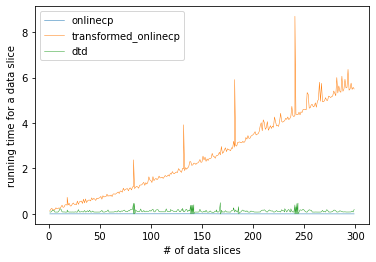

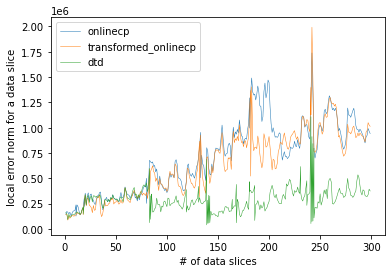

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (35 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.3697028160095215

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0008094310760498047
1th_iter: 0.001360177993774414 140981.5240178766 0
2th_iter: 0.0009827613830566406 159420.98391888072 1.0083775584529469
3th_iter: 0.0009913444519042969 91842.00382468155 -0.4715156036406556
4th_iter: 0.0012857913970947266 144217.72855629175 0.6832183439806893
5th_iter: 0.0013041496276855469 117496.32640751865 -0.01556167349199764
6th_iter: 0.0012857913970947266 114969.51735399775 -0.07906531233787724
7th_iter: 0.0012788772583007812 143097.41855068115 0.7127258456601165
8th_iter: 0.0009698867797851562 113555.02854563114 -0.21142498968174606
9th_iter: 0.0009548664093017578 117510.95498463447 -0.07738078087569493
10th_iter: 0.0009617805480957031 128932.96636977691 0.3025929775891744
11th_iter: 0.0009496212005615234 105190.8600860207 -0.5323738134248944
12th_iter: 0.0009813308715820312 128079.87036949518 0.3142544365554961
13th_iter: 0.0009465217590332031 

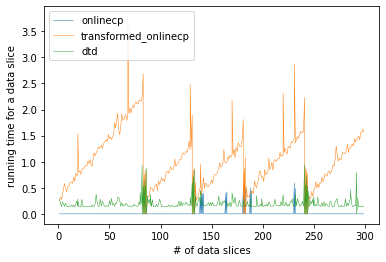

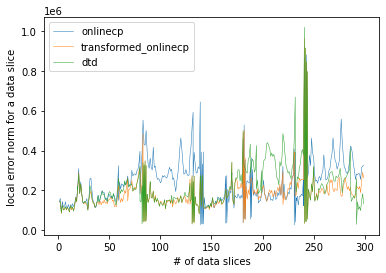

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (40 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.22081661224365234

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006394386291503906
1th_iter: 0.0011286735534667969 144793.10689412217 0
2th_iter: 0.001104116439819336 173080.57947105594 1.4201712406173945
3th_iter: 0.0011086463928222656 166397.1086430194 0.7188387402448663
4th_iter: 0.0011000633239746094 148896.46680642175 0.14760956427586874
5th_iter: 0.0011167526245117188 165320.3628086821 0.6294627566581195
6th_iter: 0.0010976791381835938 129552.46449626981 -0.5912167689617847
7th_iter: 0.0011067390441894531 149569.53038712614 0.14849370143868607
8th_iter: 0.0010976791381835938 172345.91973936197 0.983955116873483
9th_iter: 0.0010998249053955078 179983.56637200582 1.1678120819506106
10th_iter: 0.0011000633239746094 184095.96395121102 1.1897975493809032
11th_iter: 0.0010972023010253906 235341.78510848238 2.931484003265382
12th_iter: 0.0010972023010253906 250711.65792551413 2.5466395499421104
13th_iter: 0.0011012554168701172 230193.6

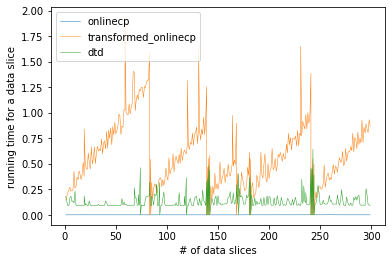

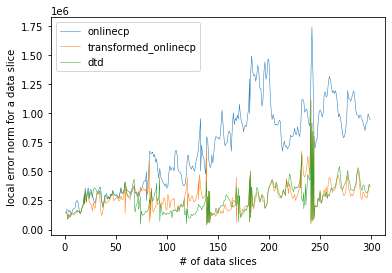

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (40 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.4395713806152344

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007812976837158203
1th_iter: 0.0014567375183105469 142025.24784443417 0
2th_iter: 0.0012507438659667969 163676.22854002088 1.0591966668121242
3th_iter: 0.0012083053588867188 90702.00583577623 -0.5140668034641926
4th_iter: 0.001210927963256836 140606.80123589523 0.5637306886983902
5th_iter: 0.0011992454528808594 114426.18091353096 -0.0898529733969709
6th_iter: 0.0012166500091552734 112852.1366947623 -0.12326105907285395
7th_iter: 0.0012063980102539062 142321.62456185985 0.6958420734413637
8th_iter: 0.0012013912200927734 150561.06585663382 0.8724162926326058
9th_iter: 0.0012102127075195312 127522.18233865424 0.11563223245151655
10th_iter: 0.0012123584747314453 117719.17314757535 -0.19456510596839438
11th_iter: 0.0012166500091552734 94972.30264067411 -0.9303389794166751
12th_iter: 0.0012097358703613281 118254.75628846054 -0.0919049593819146
13th_iter: 0.0012204647064208984 1

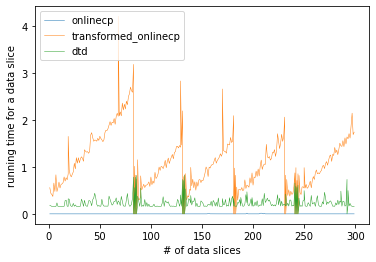

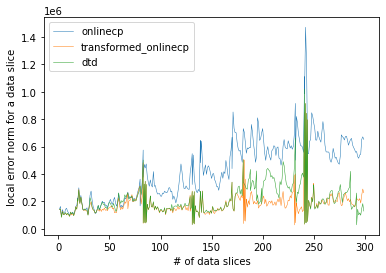

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (45 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.23453640937805176

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006492137908935547
1th_iter: 0.0010986328125 144470.42709962607 0
2th_iter: 0.0011043548583984375 172354.88001934 1.436353130081933
3th_iter: 0.0010952949523925781 154956.68698808432 0.4611445233263787
4th_iter: 0.001107931137084961 147829.25301995245 0.20605269540178006
5th_iter: 0.0011000633239746094 154670.0772851929 0.41144011197676816
6th_iter: 0.0011074542999267578 124094.8158687083 -0.7143545080845386
7th_iter: 0.0010924339294433594 149931.77965241572 0.3253393718383889
8th_iter: 0.0011591911315917969 172908.31171274238 1.2283608297034616
9th_iter: 0.0010957717895507812 179991.44907811325 1.3480374221382747
10th_iter: 0.0011038780212402344 184529.13629442386 1.345116416307517
=== REFINE(3.3844120040730976, 244190.83083234847) ===
11th_iter: 0.0023636817932128906 131178.32325680798 0
12th_iter: 0.0010919570922851562 248759.36761436771 0
13th_iter: 0.0011060237884521

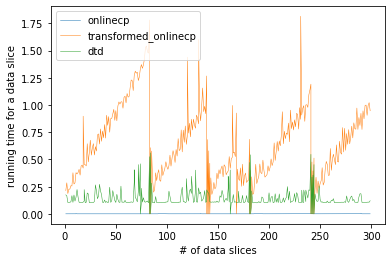

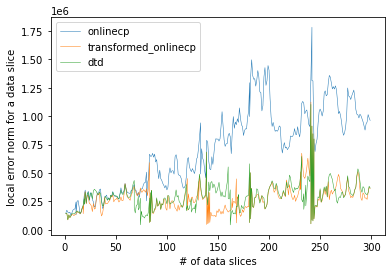

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (45 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.4103388786315918

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007236003875732422
1th_iter: 0.0012769699096679688 140684.25030622887 0
2th_iter: 0.0012576580047607422 158349.15462254267 0.9996641253705523
3th_iter: 0.0012464523315429688 90362.80316717079 -0.5034392628425173
4th_iter: 0.0012519359588623047 140434.2472848936 0.6214169338046935
5th_iter: 0.0012519359588623047 117860.81922527509 0.019524356865573647
6th_iter: 0.001252889633178711 110271.14876171238 -0.1799287216050016
7th_iter: 0.0012505054473876953 130794.0786935056 0.4167579805937762
8th_iter: 0.0012536048889160156 111261.09004900193 -0.20517213420051666
9th_iter: 0.0012488365173339844 117448.54023402497 0.006222030480332079
10th_iter: 0.009209871292114258 126693.57892655302 0.32396029065798354
11th_iter: 0.0012545585632324219 105262.80576301996 -0.464181726840462
12th_iter: 0.0012569427490234375 128675.7109509307 0.43515690124425144
13th_iter: 0.001249074935913086 118

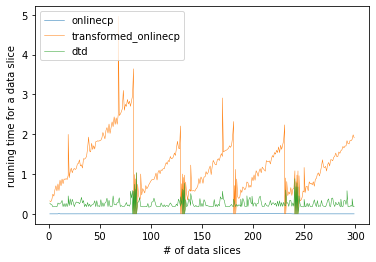

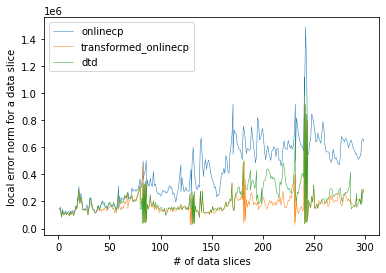

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (50 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.23648619651794434

 >> onlinecp rank-5 n_iter-1 transformed-False
init_time: 0.0006585121154785156
1th_iter: 0.0011527538299560547 157842.76351764382 0
2th_iter: 0.001138448715209961 177465.61119487317 1.1276829984948278
3th_iter: 0.0011403560638427734 217772.54774040607 1.6809201787326364
4th_iter: 0.0011279582977294922 158139.16489483064 -0.058915767400996764
5th_iter: 0.001132965087890625 157244.87550810244 -0.07404051766136974
6th_iter: 0.0011641979217529297 181090.58083411568 0.516273061735152
7th_iter: 0.0011293888092041016 219956.45293934763 1.4958419677237966
8th_iter: 0.0011358261108398438 193884.04223617865 0.5846894482340907
9th_iter: 0.0011348724365234375 164778.017982189 -0.20717232892952553
10th_iter: 0.0011336803436279297 167592.0515697519 -0.12045206333766334
11th_iter: 0.0011320114135742188 229065.1849920208 1.6526955108393804
12th_iter: 0.0011076927185058594 267182.1892227572 2.4492068579931296
13th_iter: 0.001104593276977539 283883

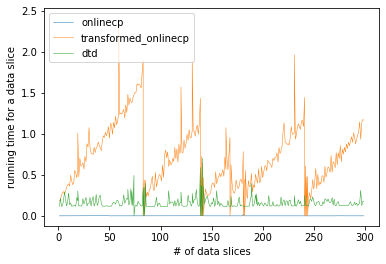

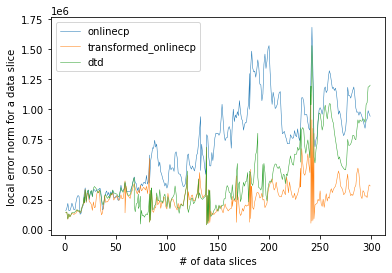

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (50 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.5567350387573242

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0007524490356445312
1th_iter: 0.0014913082122802734 146165.45507423504 0
2th_iter: 0.0012159347534179688 158984.82337156864 0.90264985004683
3th_iter: 0.0011448860168457031 88434.2405217128 -0.5400621574910439
4th_iter: 0.0011548995971679688 142653.18812351936 0.6238218261719216
5th_iter: 0.0011332035064697266 126281.99573415593 0.18517685220599914
6th_iter: 0.0011377334594726562 109561.61808929073 -0.24148688853622577
7th_iter: 0.0009708404541015625 123881.84188342268 0.16030889173669444
8th_iter: 0.0009720325469970703 117362.8575985224 -0.03818192024240867
9th_iter: 0.0009806156158447266 118491.50669526041 -0.0012258345342832408
10th_iter: 0.0009722709655761719 128338.60714237382 0.3232133670301998
11th_iter: 0.0009777545928955078 106496.63781100289 -0.4463663040745117
12th_iter: 0.0009675025939941406 127394.48200833623 0.3249956210133316
13th_iter: 0.0009853839874267578

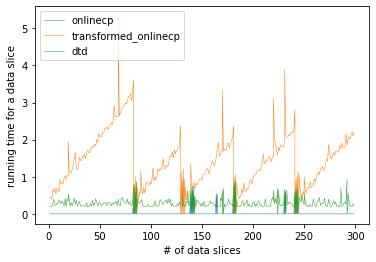

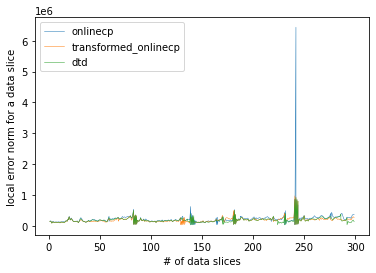

<ipython-input-29-b5523a927d4f>:13: UserWarning: Number of iteration in online cp should not exceed 1 (50 to 1).
  warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))


making init decomposition result: 0.46233081817626953

 >> onlinecp rank-10 n_iter-1 transformed-False
init_time: 0.0011043548583984375
1th_iter: 0.0018913745880126953 145644.83718236684 0
2th_iter: 0.0019643306732177734 155209.26546580286 0.853027867437312
3th_iter: 0.001905679702758789 90421.78398820787 -0.48711524581014665
4th_iter: 0.002000570297241211 141300.47067870238 0.6284499050390533
5th_iter: 0.001920461654663086 135945.98044431274 0.4299858585336871
6th_iter: 0.001918792724609375 116202.06106912995 -0.10123761600896541
7th_iter: 0.001986265182495117 124622.73598979654 0.1357861766258666
8th_iter: 0.0019659996032714844 150738.01911665904 0.9001277587858616
9th_iter: 0.001975536346435547 127689.96564352264 0.12094733703805592
10th_iter: 0.0019655227661132812 123233.63355178993 -0.026751518193349758
11th_iter: 0.0019567012786865234 101984.47742958146 -0.7398980724082512
12th_iter: 0.002008676528930664 121835.60956377402 -0.011225953450852994
13th_iter: 0.0020918846130371094 11

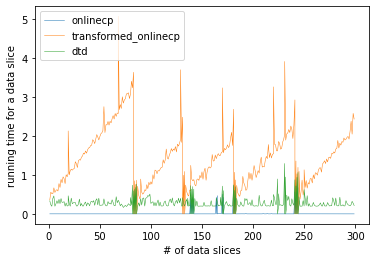

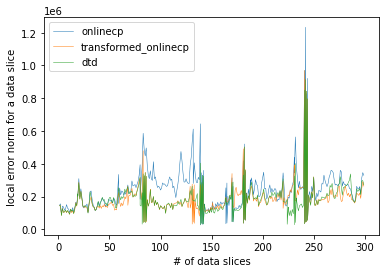

In [41]:
X = stock_data
X_stream = create_tensor_stream(X, start_to_stream=10, batch_sizes=np.full((299), 10, dtype=int))

for n_iter in range(5, 55, 5):
    for rank in range(5, 15, 5):
        execute_online_tensor_decomposition(X_stream, rank, n_iter, ul=5, ll=3, verbose=False)
execute_online_tensor_decomposition(X_stream, rank, n_iter, ul=5, ll=3, verbose=False)
# execute_online_tensor_decomposition(X_stream, rank, n_iter, ul=5, ll=3, verbose=False, methods=['onlinecp', 'dtd'])

### Usage for Online Tensor Decomposition
* Create a tensor stream (sum of batch sizes should match with total size of the tensor)
  * `create_tensor_stream(tensor, start_to_stream, batch_sizes)`
* Invoke online tensor decomposition
  * `online_tensor_decomposition(tensor stream, rank, verbose, method)`
* Construct an estimated tensor w. factors, leaving weights (=identity matrix)
  * `construct_tensor(factors)`

In [314]:
# example
X = sample_video
X_stream = create_tensor_stream(X, start_to_stream=10, batch_sizes=np.full((39), 5, dtype=int))
ktensors, verbose_list = online_tensor_decomposition(X_stream, rank=3, n_iter=1, verbose=False, method='onlinecp')

X_est = construct_tensor(ktensors[0][1])
for (weights, factors) in ktensors[1:]:
    X_est = tl.tensor(np.concatenate((X_est, construct_tensor(factors))))
compare_tensors(X, X_est)
print_tensor(np.asarray((X, X_est))[:,100,100,100:110,0])

making init decomposition result: 3.057133197784424

 >> onlinecp rank-3 n_iter-1 transformed-False
init_time: 0.05852508544921875
1th_iter: 0.05229616165161133 13029.78632848998 0
2th_iter: 0.05819869041442871 13699.374720316895 -0.535827920203835
3th_iter: 0.05153393745422363 14028.73120149932 -0.3536713909548643
4th_iter: 0.05148768424987793 14980.581378584227 0.060101089549867155
5th_iter: 0.05136513710021973 14998.070978287751 0.0635000762415962
6th_iter: 0.054677486419677734 15057.304195172326 0.08944680258004152
7th_iter: 0.06207609176635742 15014.63620830702 0.06002866033671755
8th_iter: 0.05162858963012695 14888.773405210251 -0.019411196517460264
9th_iter: 0.05153536796569824 14745.870021083269 -0.11084821665990587
10th_iter: 0.0514984130859375 14665.560525238127 -0.16078301545635393
11th_iter: 0.052742958068847656 14349.930683444609 -0.3815967813575657
12th_iter: 0.08582663536071777 14007.849252457181 -0.6215912148049366
13th_iter: 0.04984164237976074 13906.462453946873 -0.66